# Forecasting Bike Rentals in NYC

Our goal is to forecast the number of bike rides in New York City in a given day. We aim to investigate weather and seasonality effects on bike ridership. 

Datasets used:
1.   [Citi Bike System Data ](https://www.citibikenyc.com/system-data)
2.   [NOAA Weather data](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)



 ## Setup

In [3]:
from datetime import datetime, timedelta
from google.colab import drive
from prettytable import PrettyTable
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import precision_score, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import graphviz
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pydot
import seaborn as sns

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

**Read weather data from NOOA dataset**

In [5]:
path = '/content/drive/My Drive/CMPE 255 Project/data/nooa_weather/nooa_nyc_weather_features.csv'
weather_features = pd.read_csv(path)
weather_features['Date'] = pd.to_datetime(weather_features['Date'], infer_datetime_format=True)
weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...
2096,2020-09-27,261.0,194.0,8.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2097,2020-09-28,250.0,206.0,5.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2098,2020-09-29,233.0,194.0,119.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2099,2020-09-30,217.0,156.0,290.0,0.0,28.0,0.0,270.0,160.0,76.0,121.0


**Read aggregated ride count**

In [6]:
rides_tmp = []
years = range(2013, 2021)
for y in years:
  path = '/content/drive/My Drive/CMPE 255 Project/data/citibikes/rides_count_agg_{}.csv'.format(y)
  rides_y = pd.read_csv(path)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)
rides['date'] = pd.to_datetime(rides['date'], infer_datetime_format=True)
rides = rides[rides.date < '2020-03-01']
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4442 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      4442 non-null   datetime64[ns]
 1   usertype  4442 non-null   object        
 2   numrides  4442 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 138.8+ KB


## Data preprocessing

**Missing value analysis of weather data**


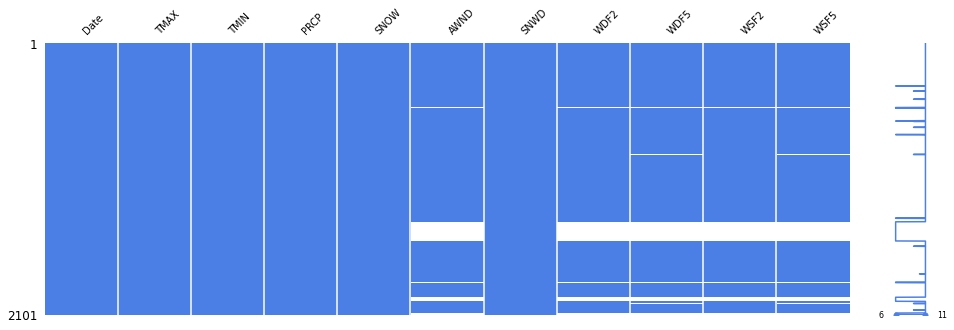

In [7]:
msno.matrix(weather_features, figsize=(16,5), fontsize=10, color=(0.3,0.5,0.9)) 


**Outlier analysis of weather data**

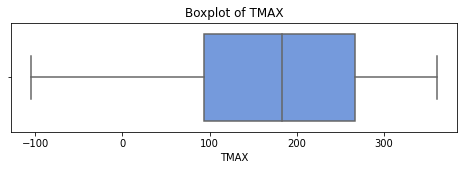

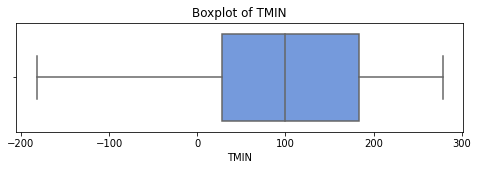

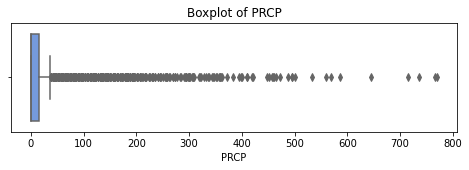

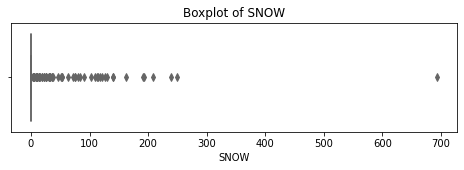

In [8]:
# TODO:Will make more sense if we do it based on season/month/week
cols = ['TMAX','TMIN','PRCP', 'SNOW'] #'AWND','SNWD', 'WDF2', 'WDF5', 'WSF2',	'WSF5'
for col in cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=col,data=weather_features, color="cornflowerblue")
    plt.title('Boxplot of '+col)
    plt.show()


**Correlation analysis**

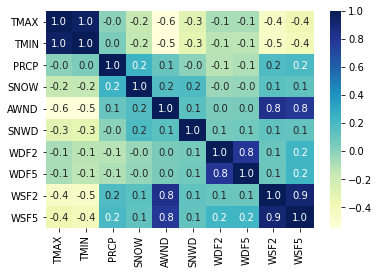

In [9]:
sns.heatmap(weather_features.corr(), annot=True, fmt=".1f", cmap="YlGnBu");

In [10]:
# TODO:Outlier/missing value treatment of weather data

**Ride data visualization**

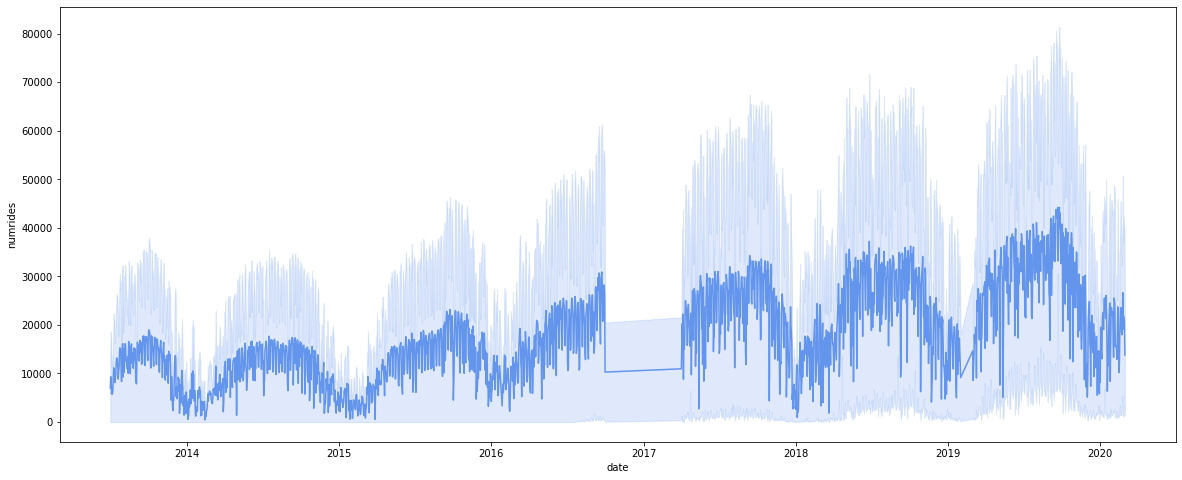

In [11]:
plt.figure(figsize=(20,8))
sns.lineplot(data=rides,x='date', y='numrides', color="cornflowerblue")


In [12]:
# TODO:Missing value analysis of ride data


**Outlier analysis of total ride count**

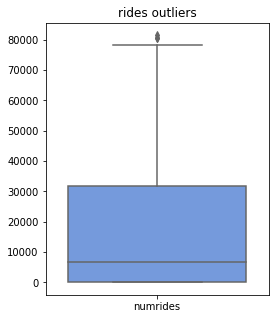

In [13]:

fig,ax=plt.subplots(figsize=(4,5))
sns.boxplot(data=rides[['numrides']], color="cornflowerblue")
ax.set_title('rides outliers')
plt.show()

## Data integration
Merge ride data and weather data 


In [14]:
rides = rides.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
rides = rides.fillna(rides.mean())
rides.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0


**Add new columns for day_of_week, week_of_year, month etc**


In [15]:
rides['day_of_week'] = pd.DatetimeIndex(rides['date']).dayofweek
rides['week_of_year'] = pd.DatetimeIndex(rides['date']).week
rides['month'] = pd.DatetimeIndex(rides['date']).month        
rides['year'] = pd.DatetimeIndex(rides['date']).year
rides.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,day_of_week,week_of_year,month,year
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,3,1,1,2015
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,3,1,1,2015
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,4,1,1,2015
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,4,1,1,2015
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,5,1,1,2015


**Encoding the date fields into binary vectors**


In [16]:
# Decision tree can handle both categorical and numerical data, but sklearn library cannot.
cols = ['day_of_week', 'week_of_year', 'month']
for col in cols:
    dummy_col = pd.get_dummies(rides[col], prefix=col, drop_first=False)
    rides = pd.concat([rides, dummy_col], axis=1)

rides = rides.drop(cols, axis=1)
rides.head()

,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,...,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,2015,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Separating data into subscriber and customer datasets**

In [17]:
subscriber_rides = rides[rides['usertype'] == 'Subscriber']
customer_rides = rides[(rides['usertype'] == 'Customer') & (rides['date'] >= '2016-01-01')]

subscriber_rides.head()

,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,...,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,2015-01-03,Subscriber,4252,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,2015,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,2015-01-04,Subscriber,7456,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0,2015,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,2015-01-05,Subscriber,14256,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0,2015,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# TODO : Scaling features


## Decision tree data modeling

**Find test train split date**

Subscriber data is selected for modeling

Latest 365 days is selected for testing

In [19]:
holdout_period = 365
max_date = subscriber_rides[['date']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
print(split_date)

2019-03-01


**Train and test data split**

In [20]:
X = subscriber_rides.drop(['date','usertype', 'year', 'numrides'], axis=1)
y = subscriber_rides['numrides']
train = subscriber_rides.loc[subscriber_rides.date <= split_date].copy()
test = subscriber_rides.loc[subscriber_rides.date > split_date].copy()
X_train = train.drop(['date','usertype', 'year', 'numrides'], axis=1)
y_train = train['numrides']
X_test = test.drop(['date','usertype', 'year', 'numrides'], axis=1)
y_test = test['numrides']

**Decision tree regressor with GridSearchCV**

In [21]:
# Setup the parameters 
param_dist = {'criterion': ['mse', 'mae'],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8, 10, 20],
              "max_leaf_nodes": [5,10, 20, 30, 50,60,80, 100]} 

tree = DecisionTreeRegressor()

# GridSearchCV to find best hyperparameters
tree_cv = GridSearchCV(tree, param_dist,verbose=1, cv=5)

# Fit to the data
tree_cv.fit(X_train, y_train)

print("Decision tree best params: {}".format(tree_cv.best_params_))
print("Best score/R-Squared::{}".format(tree_cv.best_score_))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Decision tree best params: {'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_split': 40}
Best score/R-Squared::-0.22618561131027665


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  1.3min finished


**Analyse effect of depth and no of leaf nodes**

[Text(0.5, 1.0, 'Effect of depth and no of leaf nodes and performance')]

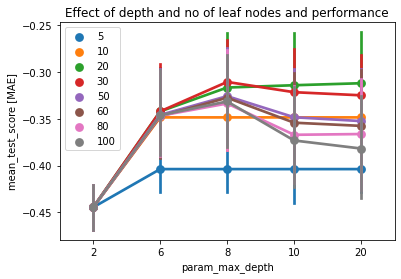

In [36]:
df = pd.DataFrame(data=tree_cv.cv_results_)

fig,ax = plt.subplots()
pp = sns.pointplot(data=df[['mean_test_score', 'param_max_leaf_nodes', 'param_max_depth']],
              y='mean_test_score',
              x='param_max_depth',
              hue='param_max_leaf_nodes',
              ax=ax)
plt.legend(loc='best')

ax.set(ylabel='mean_test_score [MAE]')
ax.set(title="Effect of depth and no of leaf nodes and performance")

**Pick best estimator and train**

In [23]:
dt_model = tree_cv.best_estimator_
dt_model.fit(X_train, y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=20,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Predictions**

In [24]:
y_pred = dt_model.predict(X_test)

##Model evaluation

In [25]:
print('R square:', metrics.r2_score(y_test, y_pred))
print('Adjusted r square:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAE', mean_absolute_error(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)))
print('MDAPE:', np.median(np.abs((y_test - y_pred) / y_test))) 


R square: -0.06375841680417871
Adjusted r square: -0.3730782401302164
MSE: 291190548.9537248
RMSE: 17064.306283987193
MAE 15079.1236663189
MAPE: 0.3178326175730586
MDAPE: 0.31247279690869895


**Feature importances**

[0.50181933 0.08311797 0.07690913 0.         0.         0.03066962
 0.         0.         0.01286734 0.         0.00809336 0.
 0.         0.         0.         0.09330539 0.10000744 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01299762 0.         0.         0.
 0.         0.02225882 0.         0.         0.         0.
 0.         0.03505302 0.02290096 0.        ]


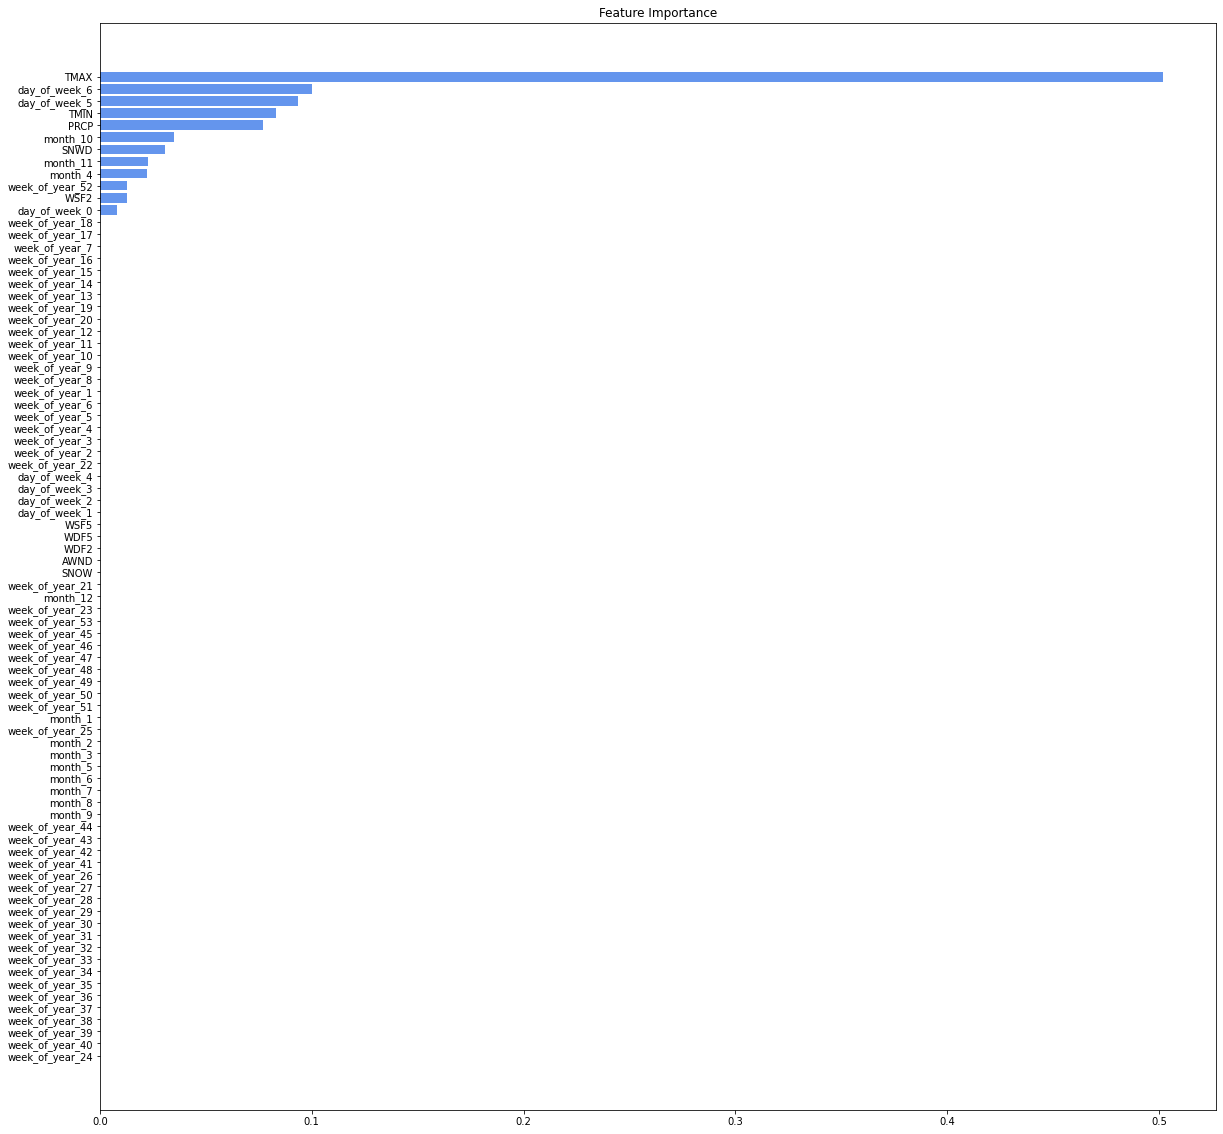

In [26]:

# Print coefficients
tree_features = dt_model.feature_importances_
print(tree_features)

# Sort feature importances
indices = np.argsort(tree_features)[::1]

# Sorting features in the order of importance
names = [X_train.columns[i] for i in indices]

fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")

plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center', color="cornflowerblue")
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.show()


**Actual vs Observed values**

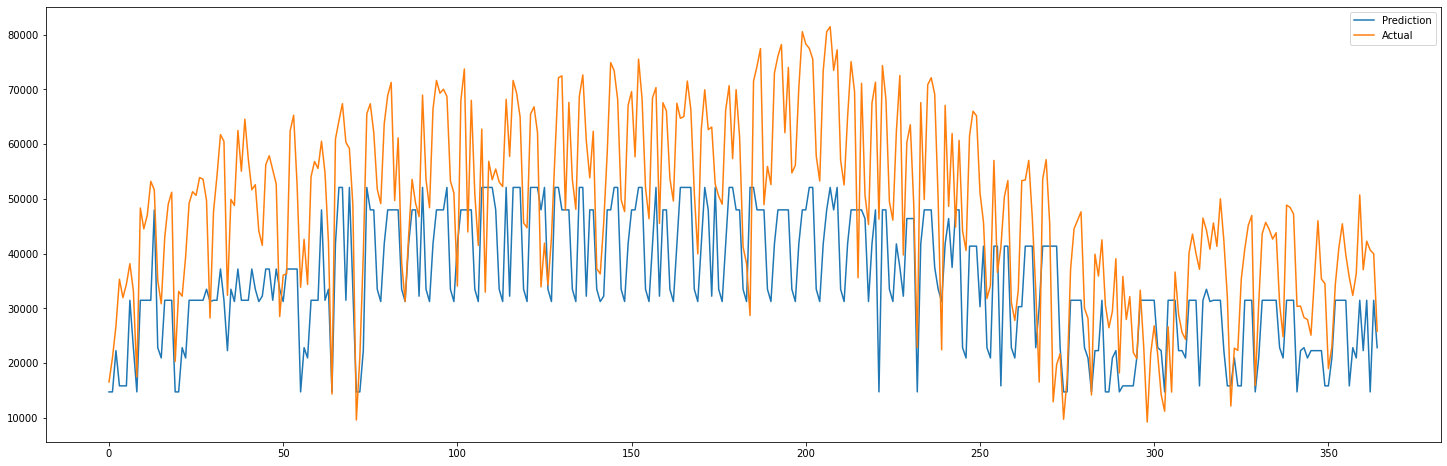

In [27]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(np.array(y_pred), label='Prediction')
ax.plot(np.array(y_test),label='Actual')
ax.legend()

# Predict bike accidents

## Load data

In [ ]:
path = '/content/drive/My Drive/CMPE 255 Project/data/bike_accidents/accident_count_agg.csv'
num_bike_collisions = pd.read_csv(path)
num_bike_collisions['date'] = pd.to_datetime(num_bike_collisions['date'], infer_datetime_format=True)
num_bike_collisions

,date,num_crashes
0,2016-03-08,2
1,2016-03-09,1
2,2016-03-11,1
3,2016-03-12,2
4,2016-03-13,5
...,...,...
1674,2020-10-09,27
1675,2020-10-10,13
1676,2020-10-11,17
1677,2020-10-12,13


## Merge weather data and accident data

In [ ]:
num_bike_collisions = num_bike_collisions.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
num_bike_collisions = num_bike_collisions.fillna(num_bike_collisions.mean())
num_bike_collisions = num_bike_collisions.rename(columns={'date':'ds', 'num_crashes':'y'})
num_bike_collisions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2016-03-08,2,194.0,83.0,0.0,0.0,15.00000,0.0,170.000000,170.000000,63.00000,85.000000
1,2016-03-09,1,250.0,67.0,0.0,0.0,10.00000,0.0,240.000000,210.000000,45.00000,98.000000
2,2016-03-11,1,200.0,89.0,15.0,0.0,27.00000,0.0,40.000000,10.000000,76.00000,116.000000
3,2016-03-12,2,150.0,44.0,0.0,0.0,23.00000,0.0,250.000000,250.000000,67.00000,103.000000
4,2016-03-13,5,167.0,100.0,0.0,0.0,16.00000,0.0,30.000000,30.000000,54.00000,81.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,2020-09-27,31,261.0,194.0,8.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1663,2020-09-28,23,250.0,206.0,5.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1664,2020-09-29,21,233.0,194.0,119.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1665,2020-09-30,27,217.0,156.0,290.0,0.0,28.00000,0.0,270.000000,160.000000,76.00000,121.000000


## Data preprocessing

In [ ]:
num_bike_collisions['day_of_week'] = pd.DatetimeIndex(num_bike_collisions['ds']).dayofweek
num_bike_collisions['week_of_year'] = pd.DatetimeIndex(num_bike_collisions['ds']).week
num_bike_collisions['month'] = pd.DatetimeIndex(num_bike_collisions['ds']).month        
num_bike_collisions['year'] = pd.DatetimeIndex(num_bike_collisions['ds']).year
num_bike_collisions.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,day_of_week,week_of_year,month,year
0,2016-03-08,2,194.0,83.0,0.0,0.0,15.0,0.0,170.0,170.0,63.0,85.0,1,10,3,2016
1,2016-03-09,1,250.0,67.0,0.0,0.0,10.0,0.0,240.0,210.0,45.0,98.0,2,10,3,2016
2,2016-03-11,1,200.0,89.0,15.0,0.0,27.0,0.0,40.0,10.0,76.0,116.0,4,10,3,2016
3,2016-03-12,2,150.0,44.0,0.0,0.0,23.0,0.0,250.0,250.0,67.0,103.0,5,10,3,2016
4,2016-03-13,5,167.0,100.0,0.0,0.0,16.0,0.0,30.0,30.0,54.0,81.0,6,10,3,2016


In [ ]:
# Encoding categorical variables
cols = ['day_of_week', 'week_of_year', 'month']
for col in cols:
    dummy_col = pd.get_dummies(num_bike_collisions[col], prefix=col, drop_first=False)
    num_bike_collisions = pd.concat([num_bike_collisions, dummy_col], axis=1)

num_bike_collisions = num_bike_collisions.drop(cols, axis=1)
num_bike_collisions.head()

,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,...,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2016-03-08,2,194.0,83.0,0.0,0.0,15.0,0.0,170.0,170.0,63.0,85.0,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2016-03-09,1,250.0,67.0,0.0,0.0,10.0,0.0,240.0,210.0,45.0,98.0,2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2016-03-11,1,200.0,89.0,15.0,0.0,27.0,0.0,40.0,10.0,76.0,116.0,2016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2016-03-12,2,150.0,44.0,0.0,0.0,23.0,0.0,250.0,250.0,67.0,103.0,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2016-03-13,5,167.0,100.0,0.0,0.0,16.0,0.0,30.0,30.0,54.0,81.0,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Test train split


In [ ]:
holdout_period = 365

max_date = num_bike_collisions[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(split_date)

X_train = train.drop(['ds', 'y'], axis=1)
y_train = train['y']
X_test = test.drop(['ds', 'y'], axis=1)
y_test = test['y']

2019-10-02


## Model training

In [ ]:
# Setup the parameters 
param_dist = {'criterion': ['mse', 'mae'],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8, 10, 20],
              "max_leaf_nodes": [5,10, 20, 30, 50,60,80, 100]} 

tree = DecisionTreeRegressor()

# GridSearchCV to find best hyperparameters
tree_cv = GridSearchCV(tree, param_dist,verbose=1, cv=5)

# Fit to the data
tree_cv.fit(X_train, y_train)

# Print the best parameters and score
print("Decision tree best params: {}".format(tree_cv.best_params_))
print("Best score/R-Squared::{}".format(tree_cv.best_score_))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Decision tree best params: {'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_split': 40}
Best score/R-Squared::0.4907443816608829


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  2.0min finished


[Text(0.5, 1.0, 'Effect of depth and no of leaf nodes and performance')]

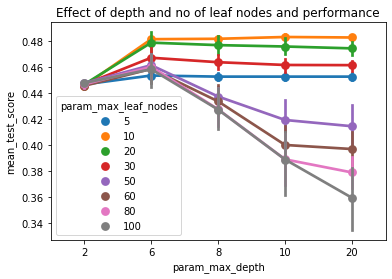

In [ ]:
df = pd.DataFrame(data=tree_cv.cv_results_)

fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score', 'param_max_leaf_nodes', 'param_max_depth']],
              y='mean_test_score',
              x='param_max_depth',
              hue='param_max_leaf_nodes',
              ax=ax)
ax.set(title="Effect of depth and no of leaf nodes and performance")

In [ ]:
dt_model = tree_cv.best_estimator_
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=20,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = dt_model.predict(X_test)

## Model evaluation

In [ ]:
print('R square:', metrics.r2_score(y_test, y_pred))
print('Adjusted r square:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAE', mean_absolute_error(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)))
print('MDAPE:', np.median(np.abs((y_test - y_pred) / y_test))) 


R square: 0.49290173971472384
Adjusted r square: 0.3454476356601399
MSE: 37.65123793272522
RMSE: 6.136060457062432
MAE 4.882090880538811
MAPE: 0.5756692621006845
MDAPE: 0.2647931303669008


**Feature importances**

[0.84756919 0.01621158 0.04992837 0.         0.00612954 0.
 0.         0.         0.         0.         0.         0.01079565
 0.         0.         0.         0.         0.         0.02207648
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02015444 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00635833 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02077643 0.         0.        ]


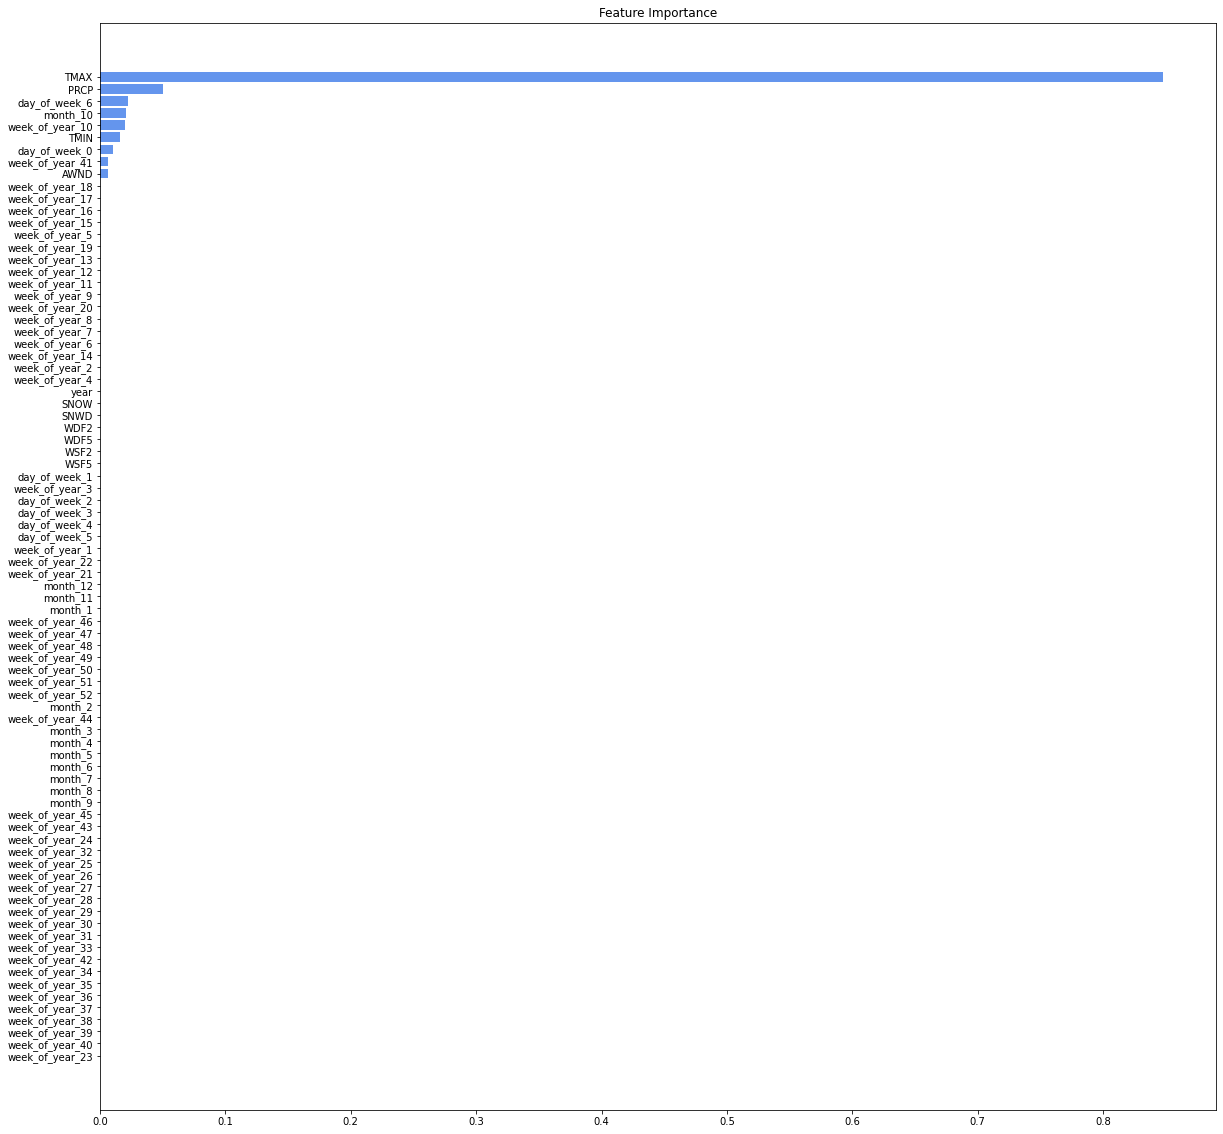

In [ ]:
# Print coefficients
tree_features = dt_model.feature_importances_
print(tree_features)

# Sort feature importances
indices = np.argsort(tree_features)[::1]

# Sorting features in the order of importance
names = [X_train.columns[i] for i in indices]

fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")

plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center', color="cornflowerblue")
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.show()

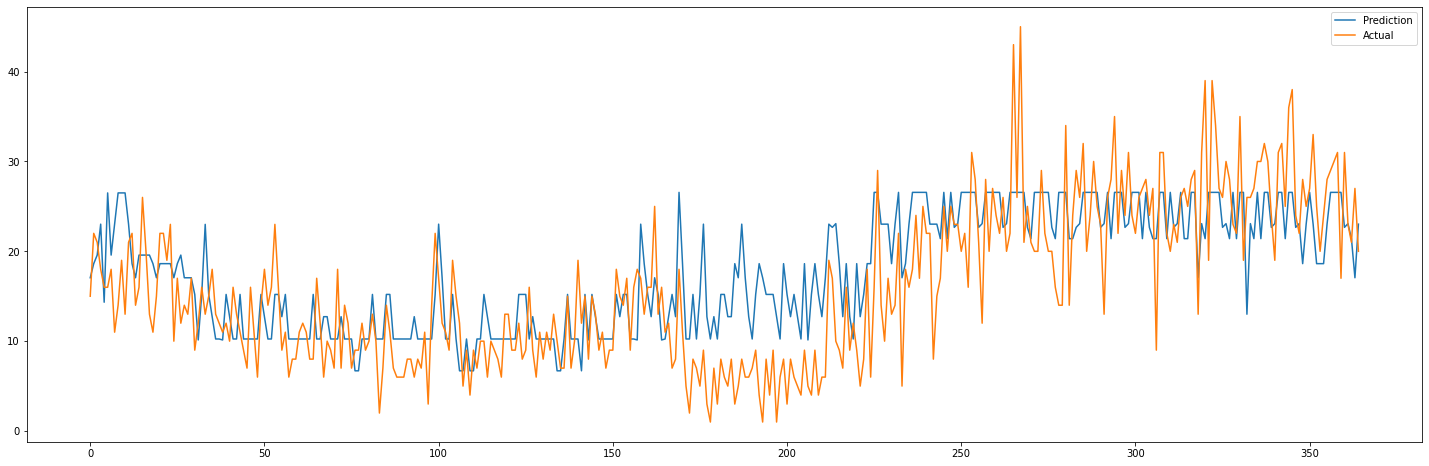

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(np.array(y_pred), label='Prediction')
ax.plot(np.array(y_test),label='Actual')
ax.legend()

# Predict trip duration based on age, gender

## Data preprocessing

In [ ]:
rides_tmp = []
years = range(2017, 2021)
for y in years:
  rides_y = pd.read_csv('/content/drive/My Drive/CMPE 255 Project/data/citibikes/rides_{}.csv'.format(y), index_col=0)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
rides

,date,usertype,birth year,gender
tripduration,,,,
195,2017-04-01,Subscriber,1966.0,1.0
585,2017-04-01,Subscriber,1995.0,1.0
665,2017-04-01,Subscriber,1987.0,1.0
262,2017-04-01,Subscriber,1961.0,1.0
134,2017-04-01,Subscriber,1967.0,2.0
...,...,...,...,...
1562,2020-08-31,Customer,2001.0,1.0
1023,2020-08-31,Customer,1993.0,2.0
600,2020-08-31,Subscriber,2002.0,1.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


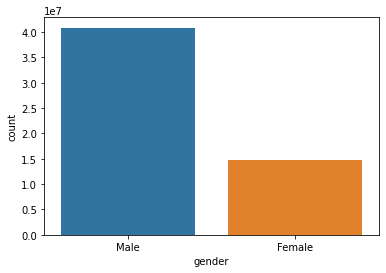

In [ ]:
# Count plot no of males and females
rides['gender'].value_counts()
splot = sns.countplot('gender', data=rides)
splot.axes.set_xticklabels(['Male', 'Female'])
plt.show()

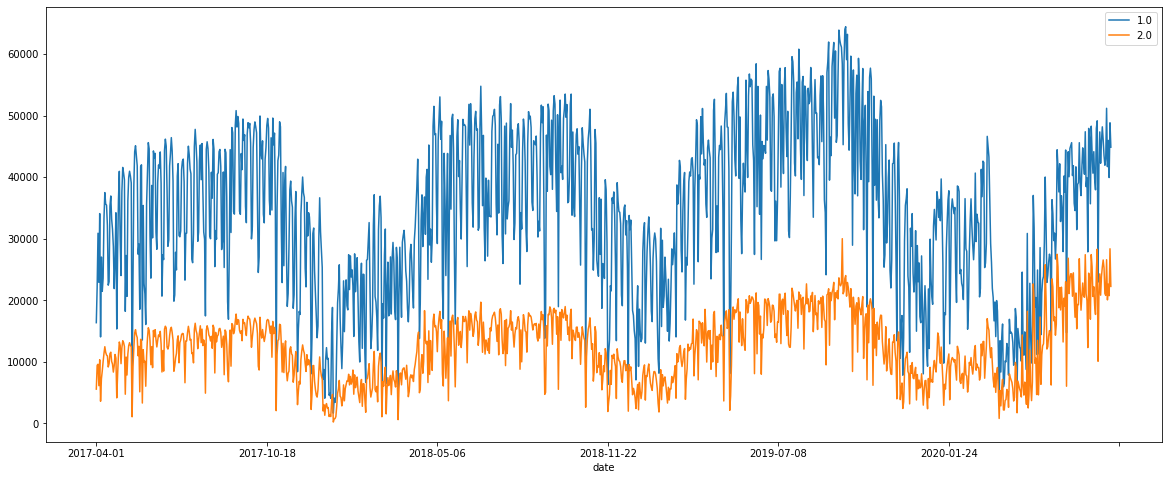

In [ ]:
gender_df = rides.groupby(['date', 'gender']).size()
gender_df = gender_df.to_frame()
gender_df = gender_df.reset_index()
gender_df.columns = ['date', 'gender', 'count']
fig, ax = plt.subplots()
for label, grp in gender_df.groupby('gender'):
    grp.plot(x = 'date', y = 'count',ax = ax, label = label, figsize=(20,8))